<a href="https://colab.research.google.com/github/TheMikeste1/cse380-notebooks/blob/master/09_2_Ponder_and_Prove_Data_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ponder and Prove Data Compression
#### Due: Saturday, 6 March 2021, 11:59 pm.

# ~DONE~ Explore Huffman Trees and Huffman Codes


Your task is examine how to compress a *special piece of information* as compactly as possible, and **calculate various compression ratios**.

Recall that the **compression ratio** of a variable-length encoding like Huffman encoding is the percentage $100(f - v)/f$, where $f$ is the number of bits per symbol of the smallest **fixed**-length encoding, and $v$ is the average number of bits per symbol with the variable-length encoding.

For example, if there were 9 different symbols in a message, $f=4$ is the number of bits of the smallest fixed-length encoding, because $2^3 = 8$ (not enough for $9$) and $2^4 = 16$ (enough and to spare). If the variable-length encoding of the message had $v=3.12$, the compression ratio would be $100(4 - 3.12)/4 \approx 22\%$.

Note that calculating the average number of bits per symbol is not strictly necessary. That's because an alternate and equivalent way is to calculate $100(ft - vt)/ft$, where $ft$ is the **total** number of bits encoded with the fixed encoding, and $vt$ is the **total** number of bits encoded with the variable-length encoding.

The *special piece of information* to be compressed is a list of the first ten million primes. This is a list that starts

|    |
|----|
|  2 |
|  3 |
|  5 |
|  7 |
| 11 |
| 13 |
| 17 |
| 19 |
| 23 |
| 29 |

  and ends

|           |
|-----------|
| 179424551 |
| 179424571 |
| 179424577 |
| 179424601 |
| 179424611 |
| 179424617 |
| 179424629 |
| 179424667 |
| 179424671 |
| 179424673 |

As ASCII text stored in a file with one prime per line, the size of this data file is slightly over 89 megabytes. The goal is to compress this down to just over 5 megabytes (5589056 bytes, to be exact). That's a 94% compression ratio!

Standard compression tools can only get about a 73% compression ratio for this ASCII data. A more clever approach is needed. Instead of compressing the list of prime numbers, compress a list of the *gaps* between them!

It doesn't save much, just the unique (occurring only once) gap size of 1 between 2 and 3, but in the spirit of de Polignac's conjecture that every *even* number appears infinitely often as a gap between consecutive primes, just consider the even-sized gaps. The result will be a list that starts with 2 (the difference between 5 and 3), 2 (the difference between 7 and 5), 4 (the difference between 11 and 7), 2 (the difference between 13 and 11), 4 (the difference between 17 and 13), 2 (the difference between 19 and 17), 4 (the difference between 23 and 19), and 6 (the difference between 29 and 23).

Generating this data is the first task. The algorithm for doing so is very straightforward:

1. Find the gaps between consecutive odd primes.
2. Store these gaps as a list of even numbers.

Tabulating the results, the first ten gaps and the last ten gaps are as follows, where the numbers after the equals signs are the gaps to list:

|                 |
|-----------------|
|  5  -   3  =  2 |
|  7  -   5  =  2 |
| 11  -   7  =  4 |
| 13  -  11  =  2 |
| 17  -  13  =  4 |
| 19  -  17  =  2 |
| 23  -  19  =  4 |
| 29  -  23  =  6 |
| 31  -  29  =  2 |
| 37  -  31  =  6 |

|                                |
|--------------------------------|
| 179424551  -  179424533  =  18 |
| 179424571  -  179424551  =  20 |
| 179424577  -  179424571  =   6 |
| 179424601  -  179424577  =  24 |
| 179424611  -  179424601  =  10 |
| 179424617  -  179424611  =   6 |
| 179424629  -  179424617  =  12 |
| 179424667  -  179424629  =  38 |
| 179424671  -  179424667  =   4 |
| 179424673  -  179424671  =   2 |

As a correctness check, see if your generated list of gaps has length 9999998.

The next step is to count how many times each gap size occurs, so that for the Huffman encoding scheme, the larger the frequency of occurrence, the smaller the number of bits encoding that gap size.

As a correctness check, here are the first ten and the last ten gap counts:

|  Gap | Count   |
|------|---------|
|    2 |  738597 |
|    4 |  738717 |
|    6 | 1297540 |
|    8 |  566151 |
|   10 |  729808 |
|   12 |  920661 |
|   14 |  503524 |
|   16 |  371677 |
|   18 |  667734 |
|   20 |  354267 |
|      |         |
|  190 |       1 |
|  192 |       3 |
|  194 |       1 |
|  196 |       1 |
|  198 |       6 |
|  202 |       2 |
|  204 |       3 |
|  210 |       4 |
|  220 |       1 |
|  222 |       1 |

Note two things from these partial gap counts:

1. Small even numbers (< 100) are well represented, larger ones (< 1000) less so.
2. Ten million primes aren't enough to have *every* even number represented; for example, 200, 206, 208, 212, 214, 216, and 218 do not appear even once.


## Response

To get started, we need the list of the first 10,000,000 primes, save 2.

In [1]:
def print_n(iterable, front_n, end_n=1):
  if len(iterable) == 0:
    print('[]')
    return
  # Assemble the front n
  string = f'[{iterable[0]}'
  for i in range(1, min(front_n, len(iterable))):
    string += f', {iterable[i]}'
  string += ', ...'

  # Update end_n if we're already passed the end of the 
  # iterable and there's not enough objects left.
  if len(iterable) - i < end_n:
    end_n = len(iterable) - i

  # Assemble the end n
  for i in range(end_n, 0, -1):
    string += f', {iterable[-i]}'
  string += ']'
  print(string)

In [2]:
#!pip install pyprimesieve

In [3]:
import pyprimesieve

# Determine what is the 10,000,000th prime.
ten_milth_prime = pyprimesieve.primes_nth(10000000)
# Generate all primes up to and including that number, barring 2.
primes = pyprimesieve.primes(ten_milth_prime + 1)[1:]

# Check the number of primes. It should be 9,999,999.
print(f"Total primes: {len(primes)}/9999999")

# Print the first few just to check.
print_n(primes, 5)

Total primes: 9999999/9999999
[3, 5, 7, 11, 13, ..., 179424673]


Now we simply need to determine that gaps for these primes.

In [4]:
def generate_gaps(primes):
    prev_prime = primes[0]
    for p in primes[1:]:
        yield p - prev_prime
        prev_prime = p

gaps = list(generate_gaps(primes))
# To verify, we'll quickly cast to a list and count the length.
# This time it should be 9,999,998.
print(f"Total Gaps: {len(gaps)}/9999998")

# Print the first few just to check.
print_n(gaps, 10, 10)

Total Gaps: 9999998/9999998
[2, 2, 4, 2, 4, 2, 4, 6, 2, 6, ..., 18, 20, 6, 24, 10, 6, 12, 38, 4, 2]


Next we'll count how many times each gap occurs.

In [5]:
from collections import defaultdict

gap_count = defaultdict(int)
for g in gaps:
  gap_count[g] += 1

In [6]:
# We'll print the listed counts to double check.
print(' 2: ', gap_count[2],    'Correct:', gap_count[2] ==	738597)
print(' 4: ', gap_count[4],    'Correct:', gap_count[4] ==	738717)
print(' 6:', gap_count[6],     'Correct:', gap_count[6] ==	1297540)
print(' 8: ', gap_count[8],    'Correct:', gap_count[8] ==	566151)
print('10: ', gap_count[10],   'Correct:', gap_count[10] ==	729808)
print('12: ', gap_count[12],   'Correct:', gap_count[12] ==	920661)
print('14: ', gap_count[14],   'Correct:', gap_count[14] ==	503524)
print('16: ', gap_count[16],   'Correct:', gap_count[16] ==	371677)
print('18: ', gap_count[18],   'Correct:', gap_count[18] ==	667734)
print('20: ', gap_count[20],   'Correct:', gap_count[20] ==	354267)
print()
print('190:', gap_count[190], 'Correct:', gap_count[190] ==	1)
print('192:', gap_count[192], 'Correct:', gap_count[192] ==	3)
print('194:', gap_count[194], 'Correct:', gap_count[194] ==	1)
print('196:', gap_count[196], 'Correct:', gap_count[196] ==	1)
print('198:', gap_count[198], 'Correct:', gap_count[198] ==	6)
print('202:', gap_count[202], 'Correct:', gap_count[202] ==	2)
print('204:', gap_count[204], 'Correct:', gap_count[204] ==	3)
print('210:', gap_count[210], 'Correct:', gap_count[210] ==	4)
print('220:', gap_count[220], 'Correct:', gap_count[220] ==	1)
print('222:', gap_count[222], 'Correct:', gap_count[222] ==	1)

 2:  738597 Correct: True
 4:  738717 Correct: True
 6: 1297540 Correct: True
 8:  566151 Correct: True
10:  729808 Correct: True
12:  920661 Correct: True
14:  503524 Correct: True
16:  371677 Correct: True
18:  667734 Correct: True
20:  354267 Correct: True

190: 1 Correct: True
192: 3 Correct: True
194: 1 Correct: True
196: 1 Correct: True
198: 6 Correct: True
202: 2 Correct: True
204: 3 Correct: True
210: 4 Correct: True
220: 1 Correct: True
222: 1 Correct: True


Now we simply need to determine the average bit length. We'll first build the encodings, then calculate the average bit length.

In [7]:
def get_huffman_codes(value_count_dict):
  nodes = [(count, [value]) for value, count in value_count_dict.items()]
  codes = defaultdict(str)
  while len(nodes) > 1:
    # Sort so we have the rarest first
    nodes.sort()

    # Pop 2 at a time
    node_a = nodes.pop(0)
    node_b = nodes.pop(0)

    # Update the new codes for each element in each node
    for value in node_a[1]:
      codes[value] += '0'
    for value in node_b[1]:
      codes[value] += '1'
    
    # Make a new node
    new_node = (node_a[0] + node_b[0], sorted(node_a[1] + node_b[1]))
    nodes.append(new_node)

  return codes

In [8]:
codes = get_huffman_codes(gap_count)

In [9]:
# The sum of the all the bit lengths per gap times how many times it occurs
average_bit_length = sum(map(lambda x: len(codes[x[0]]) * x[1], gap_count.items()))
print(f"Total bits: {average_bit_length}")
average_bit_length /= sum(gap_count.values())  # Total number of occurrences
print(f"Average bit length: {average_bit_length:.3f}")

Total bits: 44712373
Average bit length: 4.471


Awesome. The average bit length is just over a single nibble, so our encoding should be at least half (since a nibble is half a byte and each prime one or more bytes). Now we need to compare this number to the total bits required to save all the primes. Each digit is 8 bits (1 byte), and there is an extra byte at the end of the line to represent a newline (in Windows this would be 2 bytes, but we'll keep it simple).

In [10]:
from math import log10, floor

def num_digits(n):
  return floor(log10(n) + 1) if n > 0 else 1

In [11]:
# We'll sum the total number of digits + the number of newlines.
# The total number of newlines is the number of primes - 1, 
# since there is no newline at the end.
average_bits_ascii = len(primes) - 1 + sum(map(num_digits, primes))
average_bits_ascii *= 8  # 8 bits per byte
print("Total Bits ASCII:", average_bits_ascii)
average_bits_ascii /= len(primes)
print(f"Average Bits ASCII: {average_bits_ascii:.3f}")

Total Bits ASCII: 747875576
Average Bits ASCII: 74.788


Finally, we need to calculate the difference as a percentage.

In [12]:
cr = 1 - average_bit_length / average_bits_ascii
print(f"Compression Percent: {cr * 100:.3f}%")

Compression Percent: 94.021%


And there's our 94% compression! It's amazing how knowledge about the data and a little bit of creative thinking can increase the efficiency of algorithms!

# ~DONE~ Determine Exact Size of Data to be Compressed


Without actually doing it, imagine creating an ASCII file containing the first ten million primes, represented in decimal, one prime per line. Calculate the size of this file, so you can show an exceptional compression ratio from it (see below).

Using a binary encoding instead of ASCII, each prime requires 32 bits (4 bytes), so the size of a binary file is easily determined.

Using a fixed-width encoding of the gap counts, however, requires knowing how many different gap sizes there are, after which the calculation is straightforward.

## Response

The size of this ASCII file was determined in the previous exercise response to be $747875576 / 8 = 93484447$ bytes.

In [13]:
total_bytes_ascii = len(primes) - 1 + sum(map(num_digits, primes))
total_bytes_ascii

93484447

Using binary encoding, we can ignore new line characters (since each prime is exactly 4 bytes). Therefore, the total number of bytes would be $4 * (10,000,000 -1) = 39,999,996$ bytes (removing 4 bytes for the prime 2).

# ~DONE~ Use Functional Python


You are encouraged to use the [anytree](https://pypi.org/project/anytree) Python library, which has a nice exporter by way of which you can graphically view trees. (You may recall using this in DM1, and thus know that **anytree** depends on [graphviz](https://graphviz.org), which you also used.)

This library uses the object-oriented features of Python to create and visualize trees. You are encouraged to use the functional features of Python as much as possible, achieving your results not by using some existing third-party libraries for building Huffman Trees and Codes, but writing your own code as cleanly and elegantly as you can.

## Response

In [14]:
!pip install anytree

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import anytree as at

def merge_node_names(a, b):
  parts = list(map(int, a.name.split(', ')))
  parts += list(map(int, b.name.split(', ')))
  parts.sort()
  return ', '.join(map(str, parts))


def create_huffman_anytree(nodes:[at.Node]):
  # Guards!
  if len(nodes) <= 0:
      return None
  if len(nodes) == 1:
      return nodes[0]

  # Sort so we have the rarest first
  nodes.sort(key=lambda node: (node.count, node.name))
  # Grab the two nodes we want to combine
  a = nodes[0]
  b = nodes[1]
  # Recursively build the tree
  return create_huffman_anytree(nodes[2:] + [
      at.Node(merge_node_names(a, b),
              count=a.count + b.count,
              children=[a, b])])

In [16]:
from anytree.exporter import DotExporter

# Note this sometimes crashes due to a permission error. Usually you just have to reconnect to your interpreter.
root = create_huffman_anytree(
    list(map(lambda x: at.Node(str(x[0]), count=x[1]),
             gap_count.items())))
print("Finished building tree. Making graph...")
DotExporter(root).to_picture("gap_tree.png")
print("Finished making graph.")

Finished building tree. Making graph...
Finished making graph.


You can view the image in your working directory if you'd prefer to zoom in.

### Image

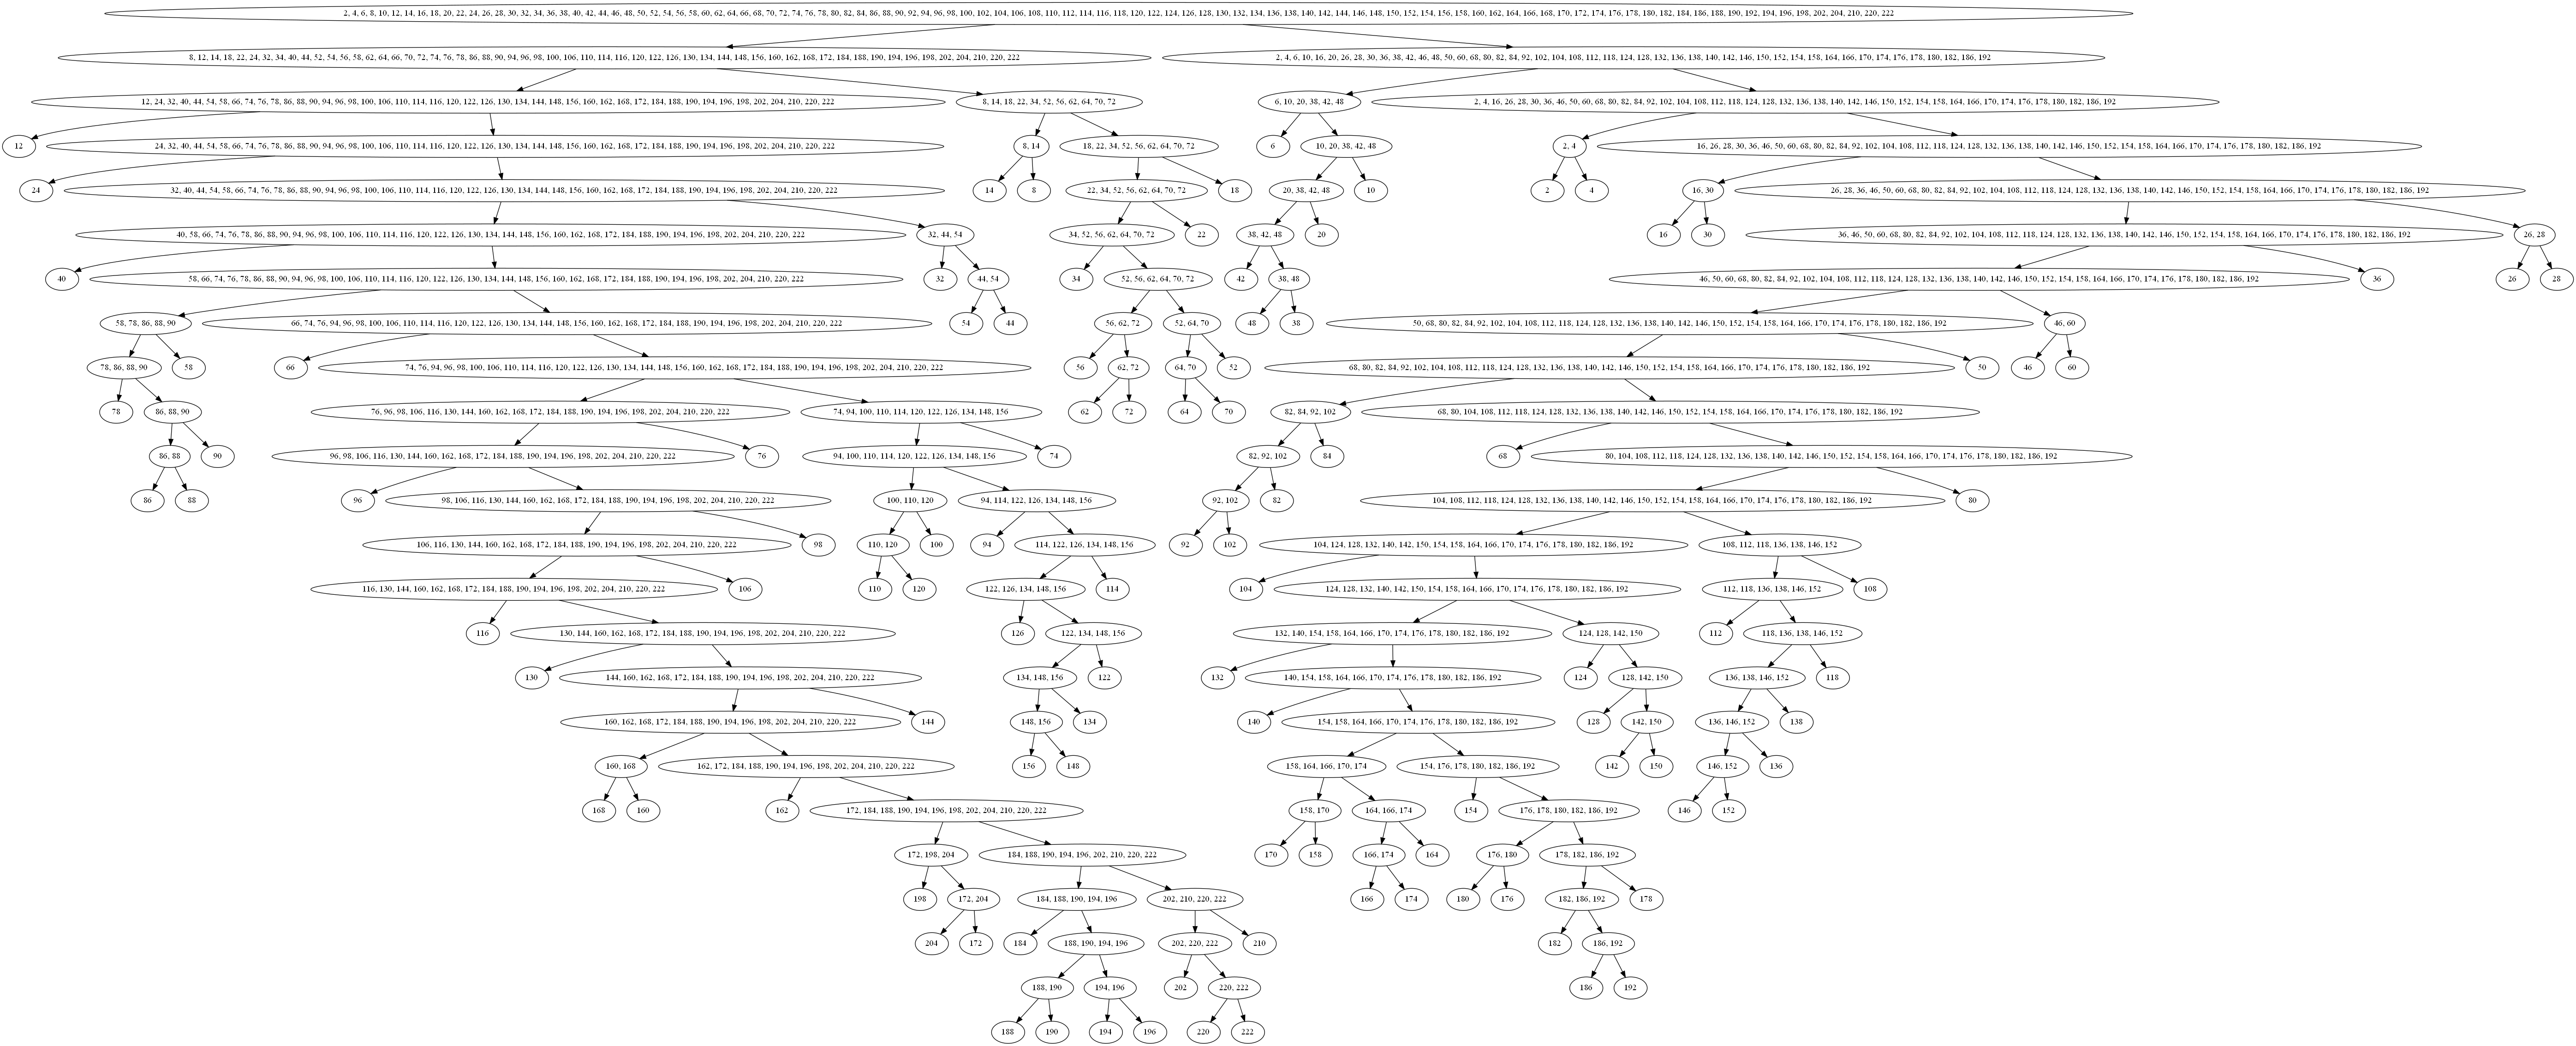

# ~DONE~ Achieve Target Compression Ratios

Your solution should correctly compute the following three compression ratios:

| Ratio       | Value              |
|-------------|--------------------|
| From fixed  | 36.125168653605158 |
| From binary |              86.03 |
| From ASCII  |              94.02 | 


## Response

In [17]:
cr = 1 - average_bit_length / average_bits_ascii
print(f"ASCII Compression Percent: {cr * 100:.3f}%")

ASCII Compression Percent: 94.021%


In [18]:
# 4 bytes per prime, 8 bits per byte
average_binary_bits = 4 * len(primes) * 8
print("Total binary bits:", average_binary_bits)
average_binary_bits /= len(primes)
# Surprise, the answer is 4 bytes * 8 bits per byte = 32 bits
print(f"Average binary bits: {average_binary_bits:.2f}")

Total binary bits: 319999968
Average binary bits: 32.00


In [19]:
cr = 1 - average_bit_length / average_binary_bits
print(f"Binary Compression Percent: {cr * 100:.3f}%")

Binary Compression Percent: 86.027%


We need to calculate the minimum fixed-length of these numbers. There are a few ways to do this. One is assigning `0b0001` to the first relevant prime (in this case, 3), another being `0b0001` meaning the number 1. We'll try both.

In [20]:
from math import log2, ceil
# 0b0001 means 1
bits_fixed = ceil(log2(ten_milth_prime))
print("Total fixed @ 1 bits:", bits_fixed * len(primes))
print(f"Average fixed @ 1 bits: {bits_fixed:.2f}")

cr = 1 - average_bit_length / bits_fixed
print(f"Fixed @ 1 Compression Percent: {cr * 100:.3f}%")

print()

# 0b0001 means first relevant prime (RP)
bits_fixed = ceil(log2(len(primes)))
print("Total fixed @ RP bits:", bits_fixed * len(primes))
print(f"Average fixed @ RP bits: {bits_fixed:.2f}")

cr = 1 - average_bit_length / bits_fixed
print(f"Fixed @ RP Compression Percent: {cr * 100:.3f}%")

Total fixed @ 1 bits: 279999972
Average fixed @ 1 bits: 28.00
Fixed @ 1 Compression Percent: 84.031%

Total fixed @ RP bits: 239999976
Average fixed @ RP bits: 24.00
Fixed @ RP Compression Percent: 81.370%


Neither of these seem to be what the table shows. Perhaps more clarity in the question is needed.

Let's try fixing the bit length of the gap sizes.

In [21]:
bits_fixed = ceil(log2(len(gap_count)))
print("Total fixed @ Gaps bits:", bits_fixed * len(primes))
print(f"Average fixed @ Gaps bits: {bits_fixed:.2f}")

cr = 1 - average_bit_length / bits_fixed
print(f"Fixed @ Gaps Compression Percent: {cr * 100:.3f}%")

Total fixed @ Gaps bits: 69999993
Average fixed @ Gaps bits: 7.00
Fixed @ Gaps Compression Percent: 36.125%


There we go. We have achieved all compression ratios.

# ~DONE~ My Report on What I Did and What I Learned

## Fun


Huffman trees how to encode data has been something I've been interested in since I discovered them. I always enjoy a good tree or compression challenge, and this one was no different.

## New

I learned that the way you look at the data changes how you think to encode it. If I were to simply take the primes as they are, I would probably encode them either with binary encoding, character/ASCII encoding, or, with some thought, a smaller fixed-length encoding. I likely would never have thought to encode the gaps, which is clearly more space efficient than all other attempted options.

## Meaningful


Trees are arguably one of the most important data structures in modern programming. I feel it is meaningful whenever we work with trees and use them in new applications.

## Other

**Collaborators:**\
Michael Hegerhorst - Author

# ~DONE~ What is True?
Click on each warranted checkbox to toggle it to True (or back to False). 

NOTE: *This only works in Colab. If you run it in some other Jupyter notebook client/server environment you may have to change False to True (or vice versa) manually.*

This self-assessment is subject to revision by a grader.

In [22]:
#@markdown ## What is True about what I did?
#@markdown ### I had fun.
cb00 = True #@param {type:'boolean'}
#@markdown ### I learned something new.
cb01 = True #@param {type:'boolean'}
#@markdown ### I achieved something meaningful, or something I can build upon at a later time.
cb02 = True #@param {type:'boolean'}
#@markdown ## What is True about my report?
#@markdown ### I wrote a sufficient number of well-written sentences.
cb03 = True #@param {type:'boolean'}
#@markdown ### My report is free of mechanical infelicities.
cb04 = True #@param {type:'boolean'}
#@markdown ### I used Grammarly (or something better described in my report) to check for MIs.
cb05 = True #@param {type:'boolean'}
#@markdown ### I reported on any connections I found between these problems and something I already know. 
cb06 = True #@param {type:'boolean'}
#@markdown ### I reported who were and what contribution each of my collaborators made.
cb07 = True #@param {type:'boolean'}
#@markdown ## What is True about my calculations?
#@markdown ### I correctly calculated the number of times each gap size occurs. 
cb08 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the number of bits per gap size with a fixed encoding.
cb09 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the total number of bits encoded with the Huffman encoding.
cb10 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the total number of bits encoded with the fixed encoding.
cb11 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the compression ratio from this fixed encoding.
cb12 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the size of the first ten million primes encoded as 32-bit integer binary data.
cb13 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the compression ratio from the binary size.
cb14 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the size of the first ten million primes encoded as ASCII data.
cb15 = True #@param {type:'boolean'}
#@markdown ### I correctly calculated the compression ratio from the ASCII size (just the primes, nothing else).
cb16 = True #@param {type:'boolean'}

## DO NOT CHANGE ANYTHING IN THE NEXT CODE CELL!!
### Delete this cell and the following ones before submitting your work.

In [23]:
points_for_what_I_did = [5]*3
points_for_my_report = [8]*5
points_for_my_calculations = [5]*9
points = points_for_what_I_did + points_for_my_report + points_for_my_calculations
# cb is short for checkbox
total = sum(map(lambda n, p: p if eval(f'cb{n:02}') else 0,
                range(len(points)), points))             
total

100

# For graders

In [24]:
#@markdown ---
number_of_MIs_found = 0 #@param {type: 'slider', min: 0, max: 5}
#@markdown ---
